# Setup

In [3]:
import tensorflow as tf
import tfx

In [4]:
from pathlib import Path
import os, pandas as pd
from fastcore.all import *

In [5]:
import fastaudio

/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [6]:
NB_DIR = Path.cwd()
#LOCAL_DATA = NB_DIR/'..'/'data'
DATA = Path('/home/oyvind/Documents/DAT255/data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'

In [7]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

In [8]:
AUDIO_TAGGING.ls()

(#6) [Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/test_post_competition.csv'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/sample_submission.csv'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/train.csv'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/train_post_competition.csv'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_test'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train')]

# Loading data

In [9]:
df = pd.read_csv(AUDIO_TAGGING/'train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [19]:
df.shape

(9473, 3)

In [10]:
labels = df.label.unique()
print(labels)
print(len(labels))

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']
41


In [11]:
path = AUDIO_TAGGING/'audio_train'

In [12]:
path.ls()

(#9473) [Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/2a871432.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/704d6fc7.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/f5729f4f.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/84d0e459.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/0b3c0588.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/56a59a85.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/f8742dce.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/1f4a7bfe.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/151b80e7.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/c3015f33.wav')...]

# Exploring the data

In [13]:
from IPython.display import Audio

In [14]:
fnames = os.listdir(str(path))
len(fnames), fnames[:5]

(9473,
 ['2a871432.wav',
  '704d6fc7.wav',
  'f5729f4f.wav',
  '84d0e459.wav',
  '0b3c0588.wav'])

In [23]:
fn = fnames[5] # fart sound
fart = str(path/fn)
Audio(str(path/fn))

In [24]:
#import pickle

In [25]:
#with open(DATA/'path.pkl', 'wb') as f:
#    pickle.dump(path, f)

In [26]:
x, sample_rate = librosa.load(fart)

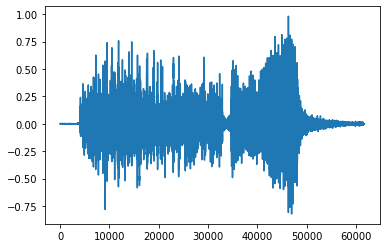

In [29]:
plt.plot(x)

```data = (ImageItemList.from_csv(PATH, folder='train', csv_file='labels.csv', cols={your_fname_col_name})
           .use_partial_data(sample_pct = .1, seed= 34)
           .random_split_by_pct(valid_pct=0.2, seed=34)
           .label_from_df(cols={your_label_cols_name})
           .transform(tfms, size = 96)
           .databunch(bs=64)).normalize(imagenet_stats)```